# Acoustic data scattering coefficients embedding with UMAP

"We will investigate Uniform Manifold Projection and Approximation (UMAP). PCA and ICA preserve quite well the pair-wise distances of data points at the costs of losing information about the local structure. Because they preserve the distances, the techniques are often used for clustering tasks later on. UMAP basically learns the high-dimensional manifold of the data and maps it into a lower dimensional space. By doing so, it preserves much better the local structure but at the costs of global structures, meaning that distances between distant data points might be distorted. Therefore, more care has to be taken, if we perform clustering in the UMAP space.

In the literature, these UMAP spaces are called atlases, since they resemble a map of the data such as the activation atlas of a convolutional neural network presented in Cartler et al. 2019. Therefore, we decided to call the UMAP spaces of a continuous seismogram a "seismogram atlas". Seismogram atlases were introduced in Steinmann et al. 2023."

## Load data and libraries

In [ ]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import umap.umap_ as umap
from sklearn.metrics import pairwise_distances
import xarray as xr
from cmcrameri import cm

import loader
%config InlineBackend.figure_format = "svg"
color_style = cm.vikO # selecting a cyclic color style for the plots

Loading model and data
Done !


## Trace stream

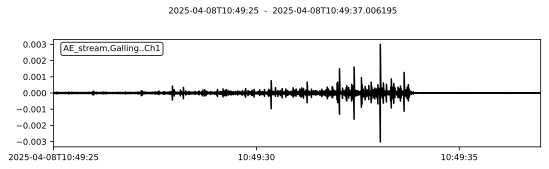

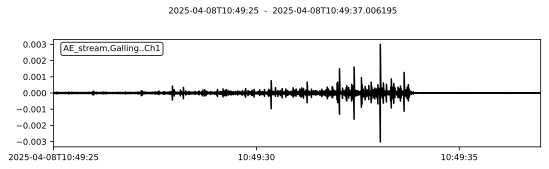

In [2]:
loader.stream.plot()

## Load, normalize and stack scattering coefficients

In [10]:
filepath_scatterings = loader.scattering_coef_path + "Scat_coef_" + loader.pooling + "_" + loader.data_file

# Load scatterings
data_scatterings, _ = pickle.load(open(filepath_scatterings, "rb"))

# Get sampling rate
sampling_rate = loader.stream[0].stats.sampling_rate
print(f"Sampling rate: {sampling_rate / 1e6} MHz")

# Extract scattering coefficients
scattering_coefficients = loader.reshape_scatterings(data_scatterings)

# Work on a copy
scatterings_normalized = scattering_coefficients.copy()

# Get the scattering coefficients (log)
scatterings_normalized = np.log(scatterings_normalized + 1e-100)

# Normalize
# scatterings_normalized.order_2.data -= scatterings_normalized.order_1.data[:, :, :, None]
# scatterings_normalized.order_1.data /= scatterings_normalized.order_1.data.std()
# scatterings_normalized.order_1.data -= scatterings_normalized.order_1.data.min()
# scatterings_normalized.order_2.data /= scatterings_normalized.order_2.data.std() 
# scatterings_normalized.order_2.data -= scatterings_normalized.order_2.data.min()

# Mask Nyquist frequencies
# scatterings_normalized.order_2.data = scatterings_normalized.order_2.where(scatterings_normalized.f1 >= scatterings_normalized.f2, 0)
# Reduce order 1 which is duplicated
# scatterings_normalized["order_1"] = scatterings_normalized.order_1.mean(dim="f2")

# Keep non na
print(f"Time samples before NaN droppping: {len(scatterings_normalized.time)}")
scatterings_normalized = scatterings_normalized.dropna(dim="time", how="any")
print(f"Time samples after NaN droppping: {len(scatterings_normalized.time)}")


def design_matrix(ds, standardize=True):
    """Design matrix of scattering coefficients."""
    n = ds.time.shape[0]
    x1 = ds.order_1.data.reshape(n, -1)
    x2 = ds.order_2.data.reshape(n, -1)
    x = np.hstack((x1, x2))
    if standardize is True:
        x -= x.mean(axis=0)
        x /= x.std(axis=0)
    return x

# Design matrix
t = scatterings_normalized.time - scatterings_normalized.time[0]
x = design_matrix(scatterings_normalized, standardize=False)
print(f"Extracted design matrix of shape: {x.shape}")

Sampling rate: 5.0 MHz
Time samples before NaN droppping: 1500
Time samples after NaN droppping: 1500
Extracted design matrix of shape: (1500, 350)


In [15]:
# Load and resample parametric data
Param = pickle.load(open(loader.param_path, "rb"))

Param.norm_cy += 0.22
Param.loc[Param.norm_cy>1,"norm_cy"] -= 1

%matplotlib widget
plt.figure()
plt.plot(Param.norm_cy,Param.PARA1)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'norm_cy'

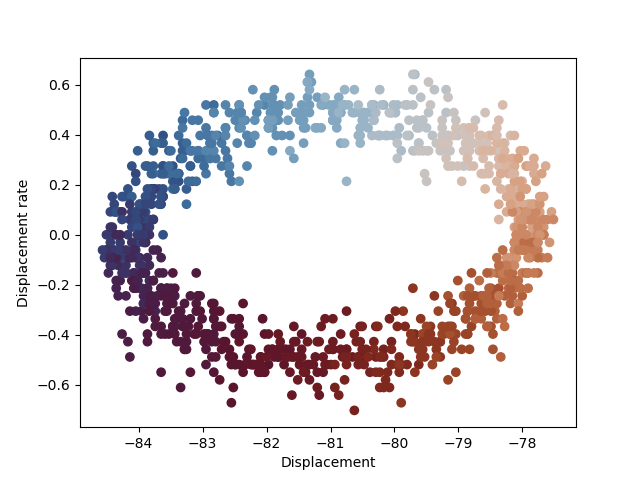

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


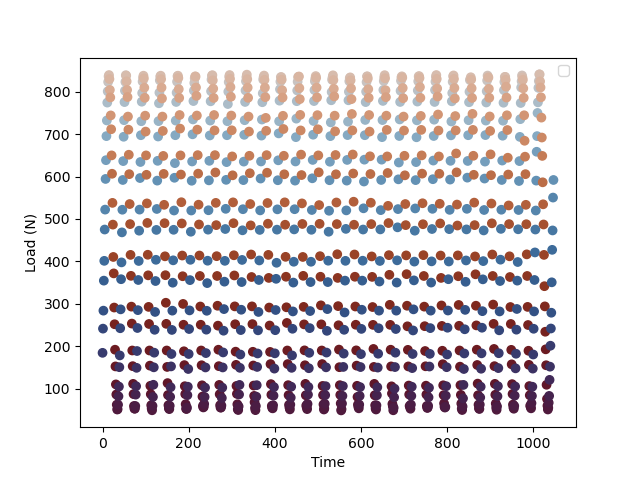

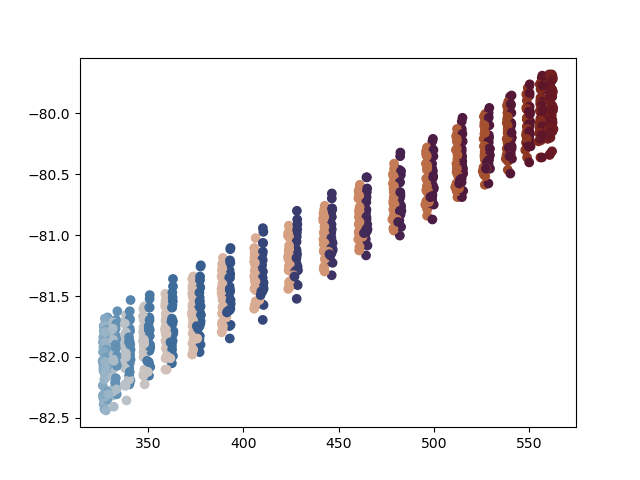

In [5]:
plt.figure()
smooth = Param['PARA2'].rolling(10).mean()
plt.scatter(smooth, smooth.diff(), c=Param.norm_cy,cmap=color_style)
plt.xlabel('Displacement')
plt.ylabel('Displacement rate')
plt.show()

plt.figure()
plt.scatter(np.arange(len(Param.PARA2)),Param.PARA1, c=Param.norm_cy,cmap=color_style)
plt.xlabel('Time')
plt.ylabel('Load (N)')
plt.legend()
plt.show()

plt.figure()
smooth_1 = Param['PARA1'].rolling(30).mean()
smooth_2 = Param['PARA2'].rolling(30).mean()
# plt.scatter(smooth_1, smooth_2, c=np.arange(len(smooth)))
plt.scatter(smooth_1, smooth_2, c=Param.norm_cy,cmap=color_style)
plt.show()

# UMAP apply

In [12]:
umap_model = umap.UMAP(n_components=2,random_state=42,n_neighbors=15, min_dist=0.1, n_jobs=-1)
embedding = umap_model.fit_transform(x)

/home/delaselt/miniconda3/envs/scatnet_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/delaselt/miniconda3/envs/scatnet_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [13]:
from scipy.interpolate import interp1d

# Defining colors from parametric measures
x_p = Param.norm_cy.values
t_p = (Param.time - Param.time.iloc[0]).values
isna = np.isnan(x_p)
x_p = x_p[~isna]
t_p = t_p[~isna]
interpolator = interp1d(t_p, x_p, bounds_error=False, fill_value=0)
color_i = interpolator(t)

# Visualize the UMAP results
plt.close()
fig, ax = plt.subplots(1,2,figsize=(9, 7),gridspec_kw={'width_ratios': [5, 1]})
im = ax[0].scatter(embedding[:,0],embedding[:,1],c=color_i,s=10, alpha=0.9,cmap=color_style)
ax[0].set_ylabel("UMAP 2")
ax[0].set_xlabel("UMAP 1")

# add a second graph vertically, on the right side, containing a single period of a sinusoidal signal colored with the same colormap
t_sin = np.linspace(0.75, 1.75, len(color_i))

max_load = Param.PARA1.max()
min_load = Param.PARA1.min()
load = (max_load-min_load)/2*np.sin(2 * np.pi * t_sin)+(max_load+min_load)/2
im = ax[1].scatter(t_sin, load, c=t_sin, cmap=color_style, s=30,alpha=0.7) 
ax[1].set_ylabel("Load (N)")

# place y ticks on the right
ax[1].yaxis.tick_right()
# move the y-axis label to the right
ax[1].yaxis.set_label_position("right")
ax[1].set_xticks([])
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0)  # Adjust the width space between subplots

plt.show()

NameError: name 'Param' is not defined

In [78]:
# save the figure in pdf format including the name the umap parameters, the channel and the pooling. The file will be saved in the directory precised in the loader.py file
save_path = loader.fig_path+"umap-"+str(umap_model.n_neighbors)+"-"+str(umap_model.min_dist)+"_"+loader.data_file[7:-4]+"_"+loader.pooling+"_o1-substract_norm-min.pdf"
fig.savefig(save_path,bbox_inches='tight')

## Atlas UMAP with RMS

/home/delaselt/miniconda3/envs/scatnet_env/lib/python3.12/site-packages/xarray/core/computation.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


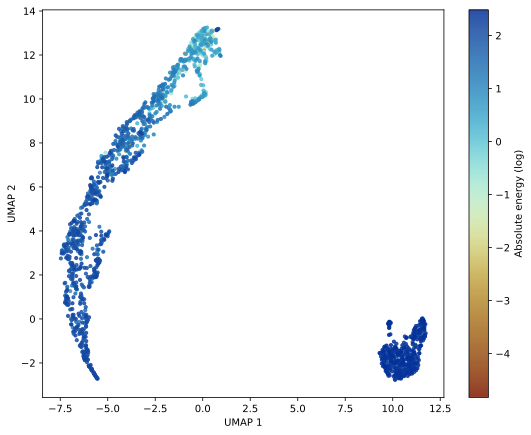

In [14]:
# Defining colors from parametric measures

# saturate values of ABS-ENERGY
# x_p = Param["ABS-ENERGY"].clip(0,1000).values
# # x_p = Param["ABS-ENERGY"].values
# t_p = (Param.time - Param.time.iloc[0]).values
# isna = np.isnan(x_p)
# x_p = x_p[~isna]
# t_p = t_p[~isna]
# interpolator = interp1d(t_p, x_p, bounds_error=False, fill_value=0)
# color_i = interpolator(t)

# If timestamps if used
color_i = t

# Visualize the UMAP results
plt.close()
fig2= plt.figure(figsize=(9, 7))
# fill the scatter plot with the colors defined by the parametric measures
im = plt.scatter(embedding[:,0],embedding[:,1],c=np.log(color_i),s=10, alpha=0.85, cmap=cm.roma ) # use batlow colormap for linear time
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")

# add colorbar
cbar = plt.colorbar(im)
cbar.set_label("Absolute energy (log)")
# cbar.set_label("Time (s)")

# zoom in the plot
# plt.xlim(-4.73,15.82)
# plt.ylim(-5.6,5.6)

plt.show()

In [80]:
# save the figure in pdf format including the name the umap parameters, the channel and the pooling. The file will be saved in the directory precised in the loader.py file
# save_path = loader.fig_path+"Time_umap-"+str(umap_model.n_neighbors)+"-"+str(umap_model.min_dist)+"_"+loader.data_file[7:-4]+"_"+loader.pooling+".pdf"
save_path = loader.fig_path+"NRJ_umap-"+str(umap_model.n_neighbors)+"-"+str(umap_model.min_dist)+"_"+loader.data_file[7:-4]+"_"+loader.pooling+"_o1-substract_norm-min.pdf"
fig2.savefig(save_path,bbox_inches='tight')

## Explorateur UMAP

In [9]:
# import waveforms

# Get atlas and 2-D PCA
# atlas_coordinates = atlas.load()
# times = scattering_coefficients.load().time
umap_df = pd.DataFrame(
    embedding, 
    columns=["UMAP1", "UMAP2"],
    index=t
)

import obspy
umap_df.index = [obspy.UTCDateTime(time) for time in umap_df.index]

index = 0

y_limits = -0.01, 0.01
plt.close("all")

# Load the first waveform
# start = umap_df.index[index]
# end = stream.segment_duration
# trace = waveforms.read(start, processing=config.waveforms["processing"])[0]
trace = loader.segments[index]
trace_times = np.arange(len(trace)) / sampling_rate

# Initialize the figure
fig, ax = plt.subplots(
    ncols=2,
    gridspec_kw={"width_ratios": [1, 3], "wspace": 0.1},
    figsize=(10, 2.7),
    # constrained_layout=True,
)

# Plot the UMAP
scatter = ax[0].scatter(umap_df.UMAP1.values, umap_df.UMAP2.values, s=5, c=color_i, lw=0, cmap=cm.batlow)
(highlight,) = ax[0].plot(
    umap_df.UMAP1.iloc[index], umap_df.UMAP2.iloc[index], "r+", lw=0.5, ms=10
)
ax[0].set_xlabel("UMAP 1")
ax[0].set_ylabel("UMAP 2")
ax[0].grid()
ax[0].set_title("Click one point")

# Plot the time series
(series,) = ax[1].plot(trace_times, trace, "k", rasterized=True, lw=0.4)
energy = ax[1].axhline(np.sqrt(np.mean(trace**2)), color="r", lw=0.5)
median = ax[1].axhline(np.sqrt(np.median(trace**2)), color="b", lw=0.5)
ax[1].set_ylim(*y_limits)
ax[1].set_ylabel("Amplitude (counts)")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_title("Watch the waveform")
ax[1].grid()
ax[1].legend(
    ["Waveform", "Root mean square", "Median absolute deviation"],
    loc="upper right",
)


def on_click(event):
    if event.inaxes == ax[0]:
        # Find the nearest point
        distances = np.sqrt(
            (umap_df.UMAP1 - event.xdata) ** 2 + (umap_df.UMAP2 - event.ydata) ** 2
        )
        nearest_index = np.argmin(distances)

        # Update the highlighted point
        highlight.set_data(
            [umap_df.UMAP1.iloc[nearest_index]], [umap_df.UMAP2.iloc[nearest_index]]
        )

        # Update the time series
        # nearest_time = waveforms.UTCDateTime(str(umap_df.index[nearest_index]))
        # trace = waveforms.read(
        #     nearest_time, processing=config.waveforms["processing"]
        # )[0]
        trace = loader.segments[nearest_index]

        series.set_data(trace_times, trace)
        energy.set_ydata([np.sqrt(np.mean(trace**2))])
        median.set_ydata([np.sqrt(np.median(trace**2))])

        fig.canvas.draw_idle()


fig.canvas.mpl_connect("button_press_event", on_click)

plt.show()

# GIF maker

In [74]:
# Import necessary library
import imageio

# Define the function to create a GIF
def create_scatter_gif(embedding, color_data, save_path, n_frames=500, cmap=cm.batlow):
    """
    Create a GIF from a scatter plot where each frame corresponds to a subset of points.
    
    Parameters:
    - embedding: 2D array of shape (n_samples, 2) for UMAP embedding.
    - color_data: 1D array of shape (n_samples,) for coloring the points.
    - save_path: Path to save the resulting GIF.
    - n_frames: Number of frames in the GIF.
    - cmap: Colormap for the scatter plot.
    """
    # Normalize color data for consistent coloring
    norm = plt.Normalize(vmin=color_data.min(), vmax=color_data.max())
    
    # Create frames
    frames = []
    for i in range(1, n_frames + 1):
        plt.figure(figsize=(6, 6))
        subset = embedding[: int(len(embedding) * i / n_frames)]
        subset_colors = color_data[: int(len(color_data) * i / n_frames)]
        im = plt.scatter(subset[:, 0], subset[:, 1], c=subset_colors, cmap=cmap, s=15, alpha=0.9)
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.title(f"Frame {i}/{n_frames}")
        # cbar = plt.colorbar(im)
        plt.colorbar(im, norm=norm, label="Time (s)")
        plt.tight_layout()
        
        # zoom in the plot
        plt.xlim(-4.73,15.82)
        plt.ylim(-5.6,5.6)
        
        # Save the current frame to a temporary file
        temp_path = f"frame_{i}.png"
        plt.savefig(temp_path)
        plt.close()
        
        # Append the frame to the list
        frames.append(imageio.imread(temp_path))
    
    # Save all frames as a GIF
    imageio.mimsave(save_path, frames, fps=10)
    print(f"GIF saved at {save_path}")

# Example usage
save_gif_path = loader.fig_path+"NRJ_umap-"+str(umap_model.n_neighbors)+"-"+str(umap_model.min_dist)+"_"+loader.data_file[7:-4]+"_"+loader.pooling+"_zoom.gif"

color_i[0] = max(color_i)
create_scatter_gif(embedding, color_i, save_gif_path)